In [1]:
import numpy as np
from tqdm import trange, tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import scipy.stats as ss

import torch
import torch.nn as nn

In [2]:
np.random.seed(41310)
torch.manual_seed(41310)

In [3]:
class feature_dist():
    '''
    Just a little class to wrap the behaviour of the distrbutions over
    features. Defines a Gaussian distribution, allows for pdf evaluation 
    and sampling.
    '''
    def __init__(self,mean=0,sd=1):
        self.mean = mean 
        self.sd = sd
    
    def pdf(self,x):
        return(ss.norm.pdf(x,loc=self.mean,scale=self.sd))
    
    def sample(self,num):
        return np.random.normal(loc=self.mean,scale=self.sd,size = (num,1))

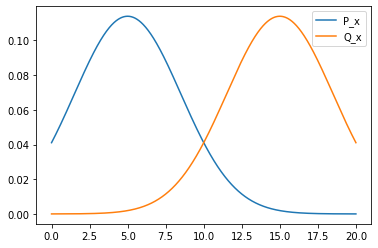

In [4]:
P_x = feature_dist(5,3.5)
Q_x = feature_dist(15,3.5)

x = np.linspace(0, 20,1000)

pdf_p = P_x.pdf(x)
pdf_q = Q_x.pdf(x)

plt.plot(x,pdf_p, label = 'P_x')
plt.plot(x,pdf_q, label = 'Q_x')
plt.legend()
plt.show()

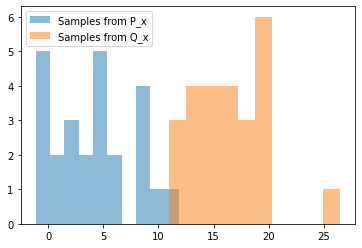

In [5]:
num_samples = 25

samples_p = P_x.sample(num_samples)
samples_q = Q_x.sample(num_samples)

plt.hist(samples_p, alpha = 0.5, label = 'Samples from P_x')
plt.hist(samples_q, alpha = 0.5, label = 'Samples from Q_x')
plt.legend()
plt.show()

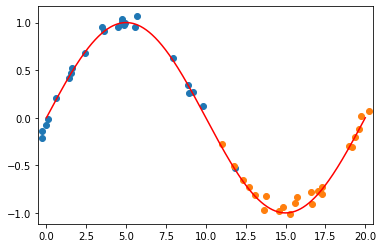

In [6]:
def y_target(x):
    #return np.sin(x)/2 + x/4 - x**2/100
    x = x/20
    return np.sin(2*np.pi*x) #+ 0.3*np.sin(4*np.pi*x)

def y_noise(n,sd):
    return np.random.normal(loc=0,scale=sd,size=(n,1))


y_samples_p = y_target(samples_p) + y_noise(num_samples, 0.05)
y_samples_q = y_target(samples_q) + y_noise(num_samples, 0.05)
true_func = y_target(x)

plt.scatter(samples_p,y_samples_p, label = 'P_x')
plt.scatter(samples_q,y_samples_q, label = 'Q_x')

plt.plot(x, true_func, c = 'r', label = 'True function')
plt.xlim(-0.5,20.5)

#plt.legend()
plt.show()
    

In [7]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 12),
            nn.Tanh(),
            #nn.Linear(12, 12),
            #nn.Tanh(),
            nn.Linear(12, 1),
        )

    def forward(self, x):
        
        return self.linear_relu_stack(x)

    def loss(self,features,targets):

        return ((self.forward(features) - targets)**2).sum()

    def train(self,features,targets,iters=500,l_rate=1e-3):

        optimizer = torch.optim.Adam(
            self.parameters(), lr=l_rate, betas=[0.1,0.01]
        )
        
        for it in tqdm_notebook(range(iters)):
            
            optimizer.zero_grad()
            loss = self.loss(features,targets)
            loss.backward()
            optimizer.step()
        print(loss)
        return

In [8]:
p_train = torch.tensor(samples_p).float()
p_target = torch.tensor(y_samples_p).float()

q_train = torch.tensor(samples_q).float()
q_target = torch.tensor(y_samples_q).float()

In [9]:
model1 = NeuralNetwork()
model1.train(p_train,p_target,iters=20000,l_rate=1e-4)

model2 = NeuralNetwork()
model2.train(q_train,q_target,iters=30000,l_rate=1e-4)

/var/folders/wp/py0z2l9105vbrwd4qfhyphlr0000gn/T/ipykernel_34043/1489549808.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(iters)):


  0%|          | 0/20000 [00:00<?, ?it/s]

tensor(0.0308, grad_fn=<SumBackward0>)


  0%|          | 0/30000 [00:00<?, ?it/s]

tensor(0.1313, grad_fn=<SumBackward0>)


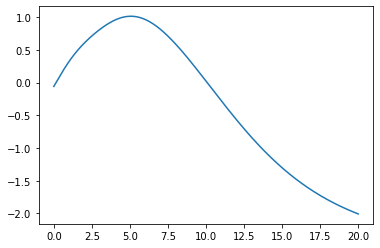

In [10]:
plt.plot(x,model1.forward(torch.tensor(x).float().reshape((1000,1))).detach())

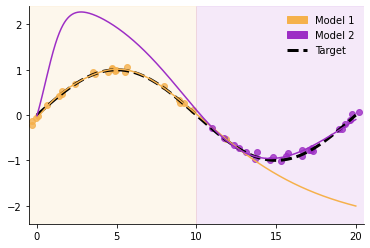

In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'


plt.scatter(samples_p,y_samples_p,c=CB91_Amber, label = 'P_x', alpha=0.8)
plt.scatter(samples_q,y_samples_q,c=CB91_Purple, label = 'Q_x', alpha=0.8)

plt.plot(x, true_func, c = 'black', label = 'True function',linewidth=3.0,linestyle='--')

x_torch = torch.tensor(x).float().reshape((1000,1))

plt.plot(x,model1.forward(x_torch).detach(),c=CB91_Amber,)
plt.plot(x,model2.forward(x_torch).detach(),c=CB91_Purple,)

#plt.hist(samples_p, alpha = 0.5, label = 'Samples from P_x')
#plt.hist(samples_q, alpha = 0.5, label = 'Samples from Q_x')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.axvspan(-5, 10, color=CB91_Amber, alpha=0.1)
plt.axvspan(10, 25, color=CB91_Purple, alpha=0.1)

plt.xlim(-0.5,20.5)
plt.ylim(-2.4,2.4)

plt.xticks([0,5,10,15,20])
plt.yticks([-2,-1,0,1,2])

model1_patch = mpatches.Patch(color=CB91_Amber, label='Model 1')
model2_patch = mpatches.Patch(color=CB91_Purple, label='Model 2')
black_line = mlines.Line2D([], [], color='black', linewidth=3.0,linestyle='--', label='Target')

plt.legend(frameon=False,handles=[model1_patch,model2_patch,black_line])
plt.show()

In [12]:
model2.loss(q_train,q_target)

tensor(0.1313, grad_fn=<SumBackward0>)

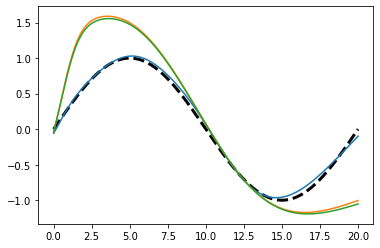

In [13]:
pred_p = model1.forward(torch.tensor(x).float().reshape((1000,1))).detach()
pred_q = model2.forward(torch.tensor(x).float().reshape((1000,1))).detach()
w_p = pdf_p / (pdf_p + pdf_q)
w_q = pdf_q / (pdf_p + pdf_q)

l_p = np.exp(model1.loss(p_train,p_target).detach())
l_q = np.exp(model2.loss(q_train,q_target).detach())

bma_w_p = l_p / (l_p + l_q)
bma_w_q = l_q / (l_p + l_q)

pred = (pred_p.squeeze()*w_p) + (pred_q.squeeze()*w_q)
pred.shape

naive_pred = (pred_p*0.5) + (pred_q*0.5)
bma_pred = (pred_p.squeeze()*bma_w_p) + (pred_q.squeeze()*bma_w_q)


plt.plot(x, true_func, c = 'black', label = 'True function',linewidth=3.0,linestyle='--')
plt.plot(x,pred)
plt.plot(x,bma_pred)
plt.plot(x,naive_pred)

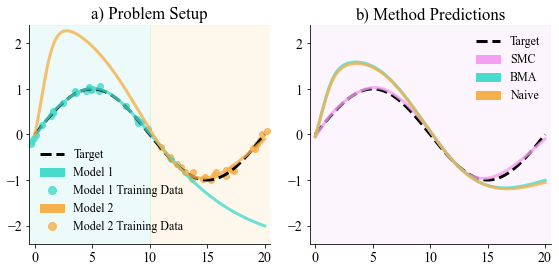

In [14]:
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 14

#matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
#matplotlib.rcParams['font.family'] = "sans-serif"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.scatter(samples_p,y_samples_p,c=CB91_Green, label = 'P_x', alpha=0.8)
ax1.scatter(samples_q,y_samples_q,c=CB91_Amber, label = 'Q_x', alpha=0.8)

ax1.plot(x, true_func, c = 'black', label = 'True function',linewidth=3.0,linestyle='--')
ax1.plot(x,model1.forward(x_torch).detach(),c=CB91_Green,linewidth=3.0,alpha=0.8)
ax1.plot(x,model2.forward(x_torch).detach(),c=CB91_Amber,linewidth=3.0,alpha=0.8)

ax1.axvspan(-5, 10, color=CB91_Green, alpha=0.1)
ax1.axvspan(10, 25, color=CB91_Amber, alpha=0.1)

model1_training = mlines.Line2D([], [], color=CB91_Green, marker='o', linestyle='None',
                          markersize=8, label='Model 1 Training Data', alpha=0.8)
model2_training = mlines.Line2D([], [], color=CB91_Amber, marker='o', linestyle='None',
                          markersize=8, label='Model 2 Training Data', alpha=0.8)

model1_patch = mpatches.Patch(color=CB91_Green, label='Model 1')
model2_patch = mpatches.Patch(color=CB91_Amber, label='Model 2')
black_line = mlines.Line2D([], [], color='black', linewidth=3.0,linestyle='--', label='Target')
ax1.legend(frameon=False,handles=[black_line,model1_patch,model1_training,model2_patch,model2_training],fontsize=12)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.title.set_text('a) Problem Setup')

ax2.plot(x, true_func, c = 'black', label = 'Target',linewidth=3.0,linestyle='--')
ax2.plot(x,pred,c=CB91_Pink,label = 'SMC',linewidth=3.0,alpha=0.8)
ax2.plot(x,bma_pred,c=CB91_Green,label = 'BMA',linewidth=3.0,alpha=0.8)
ax2.plot(x,naive_pred,c=CB91_Amber,label = 'Naive',linewidth=3.0,alpha=0.8)

scm_patch = mpatches.Patch(color=CB91_Pink, label='SMC')
bma_patch = mpatches.Patch(color=CB91_Green, label='BMA')
naive_patch = mpatches.Patch(color=CB91_Amber, label='Naive')

ax2.legend(frameon=False,handles=[black_line,scm_patch,bma_patch,naive_patch],fontsize=12)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.axvspan(-5, 25, color=CB91_Pink, alpha=0.1)
ax2.title.set_text('b) Method Predictions')

plt.setp((ax1,ax2), 
    xlim=(-0.5,20.5), 
    ylim=(-2.4,2.4),
    xticks=[0,5,10,15,20],
    yticks=[-2,-1,0,1,2],
    )

plt.tight_layout()
plt.savefig('synthetic_example_new.pdf')
plt.show()